### Import NMF and STFT libraries
and Python toolkit as well

In [1]:
!rm nmf.cpython*
!ln -s ../installer/nmf.cpython-36m-x86_64-linux-gnu.so  nmf.cpython-36m-x86_64-linux-gnu.so

In [2]:
!rm stft.cpython*
!ln -s ../../stft/installer/stft/stft.cpython-36m-x86_64-linux-gnu.so stft.cpython-36m-x86_64-linux-gnu.so

In [3]:
import stft 
import nmf

In /home/steboss/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/steboss/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/steboss/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/steboss/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/steboss/.local/lib/python3.6/site-packages/matplotlib/mpl-d

In [4]:
import scipy.io.wavfile
import matplotlib.pyplot  as plt
from mpl_toolkits.mplot3d import Axes3D
import pydub
import numpy  as np
import math
import sys,os
import seaborn as sbn
sbn.set_style("whitegrid")

### Use STFT functions to compute spectrogram from mp3

In [5]:
def readmp3(f, normalized=False):
    """MP3 to numpy array  16bit only"""
    a = pydub.AudioSegment.from_mp3(f)
    y = np.array(a.get_array_of_samples())
    if a.channels == 2:
        y = y.reshape((-1, 2))
    if normalized:
        return a.frame_rate, np.float32(y) / 2**15
    else:
        return a.frame_rate, y
    

def padding(x, windowSize):
    """Pad the signal at both ends with 0, in order to have 
    a power of 2 length"""

    zeros = np.zeros(int(windowSize/2), dtype=x.dtype)
    print(x.shape)
    print(zeros.shape)
    x = np.concatenate((zeros, x, zeros), axis=-1)
    nadd = (-(x.shape[-1]-windowSize) % int(windowSize/2)) % int(windowSize)
    zeros_shape = list(x.shape[:-1]) + [int(nadd)]
    x = np.concatenate((x, np.zeros(zeros_shape)), axis=-1)
    return x


### Read a simple C major scale

Sampling rate 22050
(74304,)
Padding signal...
(74304,)
(512,)
Dimension of the signal after boundary and padding 75776

Total number of freqs %d
 513
Total number of samples 75924
Total number of freq in Cython 513

Analysis with these parameters:
Total number of samples 75924
Windows length 1024
Hopping size 1024
(147, 513)
11025.0
Roll magnitude values
(513, 147)
Compute STFT...
plotting frequencies...
Computing magnitude in dB...


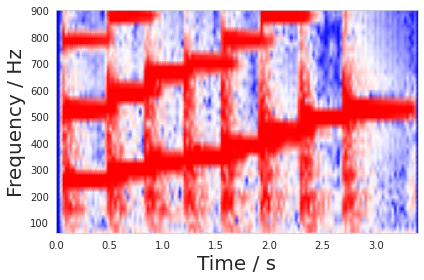

In [6]:
inputFile = "FMP_C8_Audio_C-major-scale.mp3"
extension = inputFile.split(".")[-1]
if extension =="wav":
    rate, audData = scipy.io.wavfile.read(inputFile,)
else:
    rate, audData = readmp3(inputFile)
    
print("Sampling rate {}".format(rate))
# extract the info
length = int(len(audData))
print(audData.shape)
#if audData.shape[1]>1:   
#    channel1 = audData[:,0]
#else:
#    channel1= audData
# convert to double
channel1 = audData
channel1 = np.double(channel1)
windowSize = 1024 # length of the window to analyse with STFT
hopSize = 1024  # hopsize between windows
# pad the signal based on the windowSize
print("Padding signal...")
signal = padding(channel1, windowSize)
print("Dimension of the signal after boundary and padding %d\n"% len(signal))
# create the frequencies
freq_spacing = 1.0/(rate) # the spacing
val_freq = 1.0/(windowSize*freq_spacing) # the total number of freq
N_val = math.floor(windowSize/2) + 1#
print("Total number of freqs %d\n", N_val)
frequencies = []
for i in range(0, N_val):
    frequencies.append(i*val_freq)

magnitude = stft.play(signal, rate , windowSize, hopSize)
print(max(frequencies))
print("Roll magnitude values")
magnitude = np.rollaxis(magnitude, -1, -2)
print(magnitude.shape)
print("Compute STFT...")
start_time = int(windowSize/2)
stop_time  = int(magnitude.shape[-1] - windowSize/2 +1)

time = np.arange(windowSize/2, signal.shape[-1] - windowSize/2 + 1,
                 windowSize - (windowSize/2))/float(rate)
time -= (windowSize/2)/ rate

print("plotting frequencies...")
fig = plt.figure()
ax = fig.add_subplot(111)
print("Computing magnitude in dB...")
magnitude = 20*np.log10(np.abs(magnitude))
ax.pcolormesh(time, frequencies, magnitude, vmin=0, vmax=50,cmap="bwr",shading="gouraud")
ax.set_ylabel(r"Frequency / Hz",fontsize=20)
ax.set_xlabel(r"Time / s",fontsize=20)
ax.set_ylim(60,900)#

plt.tight_layout()
plt.show()

### Compute NMF W and NMF H matrices 


In [7]:
%%time 
n_components = 7 # 7 notes played
# run NMF with STFT as input, n_components
# a maximum of 10k iterations, 
# 42 as random seed and 0 for verbose
W, H = nmf.play(magnitude, n_components, 10000, 42, 0)

Conversion of X into memoryview
Creating W array with 3591 elements
Creating H array with 1029 elements
Calling C
CPU times: user 3.01 s, sys: 25.9 ms, total: 3.04 s
Wall time: 3.05 s


In [8]:
print(W.shape)
print(H.shape)

(513, 7)
(7, 147)


### Represent W & H 

The matrix `W` contains the spectra for each component. 
For example the first component (0) refers to B4 note, whose 
fundamental frequency is 493.88. In the W plot we can see 
the multiple frequency at 123 Hz.
Component 1 and 6 are the same as they refer to C4/C5.
Deviations from the actual note frequencies are due to
frequency quantization by the DFT in STFT. In general individual
peaks will not help in note identification, instead we use the
harmonic profile that all peaks collectively outline
This example also shows that the order of the template columns in
`W`  (and the same with the activation rows of `H` ) do not have any semantics. 
Indeed, the NMF decomposition does not favor any order

`H` contains the activation time for each component. For example the 
first note played is component 1, C4. The
pairing of the nth row of H with the nth row of W describes
the two elements that made up this scene.


In [9]:
W_scaled = W
W_scaled /= np.max(np.abs(W),axis=0)

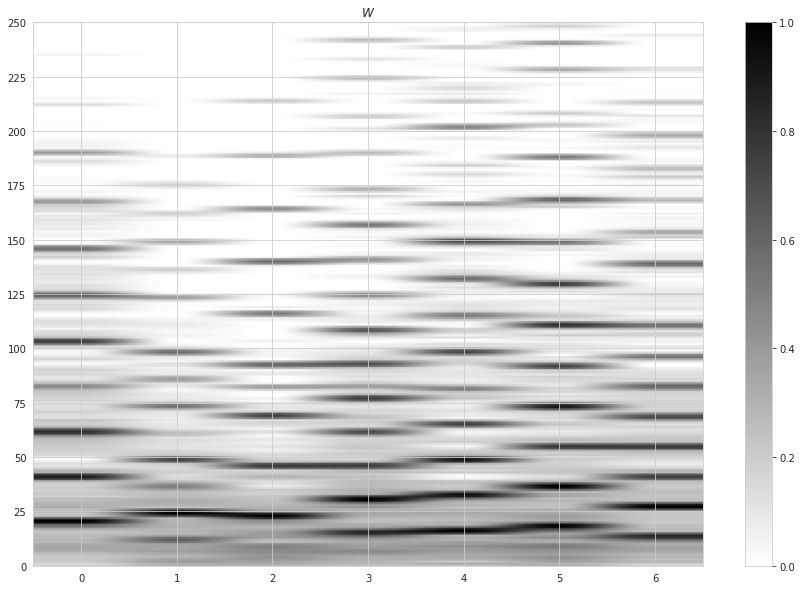

In [11]:
fig, ax = plt.subplots(figsize=[15,10])
im = ax.imshow(W_scaled, aspect='auto', origin='lower', cmap='gray_r', clim=[0, np.max(W_scaled)])
ax.set_title(r'$W$')
plt.sca(ax)
plt.colorbar(im) 
plt.ylim(0, 250)
ax.set_yticks([0,25,50,75,100,125, 150,175, 200, 225, 250])

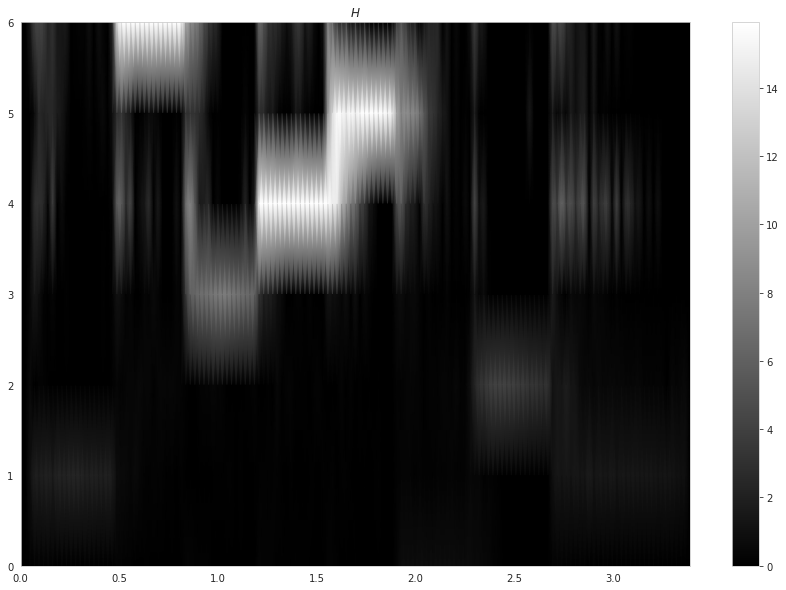

In [12]:
fig, ax = plt.subplots(figsize=[15,10])
#im = ax.imshow(H, aspect='auto', origin='lower', cmap='gray_r', clim=[0, np.max(H)/2.0])
im=ax.pcolormesh(time, np.arange(0,7), H, vmin=0, vmax=np.max(H)/2.0,cmap="gray",shading="gouraud")
ax.set_title(r'$H$')
ax.set_ylim(0,n_components-1)
plt.sca(ax)
plt.colorbar(im)   